In [1]:
import torch
import torch.nn as nn
from torch import autograd as ag
import numpy as np 
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import corner

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import datamaker
import training

from importlib import reload
reload(datamaker)
reload(training)

ModuleNotFoundError: No module named 'datamaker'

In [87]:
# Load in training data
if os.path.isfile('Cgg_samples_20tasks_1024samples.npz'):
    with np.load('Cgg_samples_20tasks_1024samples.npz') as data:
        X_train = data['X_train']
        Y_train = data['Y_train']
        survey_midpoints = data['survey_midpoints']
        survey_pz = data['survey_pz']
        qrd_pz = data['qrd_pz']

print(X_train.shape)
print(Y_train.shape)

(20, 1024, 6)
(20, 1024, 30)


In [99]:
class MAML():
    '''
        Class for MAML implemntation of an angular power spectrum emulator.
        SGD is currently hardcoded, need to provide different optimizers.
    '''
    def __init__(self, model, seed=14,
                 ):
        self.model = model
        self.seed = seed
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.rng = np.random.RandomState(seed)

    # convert numpy array to torch tensor
    def to_torch(self, arr):
        return ag.Variable(torch.tensor(arr, dtype=torch.float32).to(self.device))
    
    # send individual data batch to model for training step
    def train_on_batch(self, x ,y, step, loss_fn):
        x = self.to_torch(x)
        y = self.to_torch(y)
        self.model.zero_grad()
        y_pred = self.model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        for param in self.model.parameters():
            param.data -= step * param.grad.data

    # obtain predictions from model
    # Includes built in scaling 
    def predict(self, x):
        x = self.to_torch(x)
        return self.model(x).detach().cpu().numpy()
    
    # meta train the model
    def meta_train(self, x_train, y_train, 
                   inner_lr, outer_lr, loss_fn, 
                   spt_frac, outer_epochs, inner_epochs,
                   inner_decay=1e-4, outer_decay=1e-3, n_shots=5,
                   rec_loss=True, plot_prog=False, scale=True):
        
        # ascertaining the number of tasks and samples
        n_tasks = y_train.shape[0]
        n_samples = y_train.shape[1]
        tasks = np.arange(n_tasks)
        tasks = self.rng.permutation(tasks) # permute the order tasks are trained

        if scale:
            for i in range(n_tasks):
                scaler = StandardScaler()
                y_train[i] = scaler.fit_transform(y_train[i])
                x_train[i] = scaler.fit_transform(x_train[i])

        # isolate a random task for plotting the progress of training
        if plot_prog:
            task_plot = self.rng.choice(tasks, size=1)
            print('Plotting task_{}'.format(task_plot))
            tasks= np.delete(tasks, task_plot)
            n_tasks = len(tasks)
            rand_inds = self.rng.choice(n_samples, size=n_shots+1, replace=False)

            x_shot = x_train[task_plot, rand_inds[:-1]]
            y_shot = y_train[task_plot, rand_inds[:-1]]

            x_test = x_train[task_plot, rand_inds[-1]]
            y_test = y_train[task_plot, rand_inds[-1]]

        # repeat tasks so total meta train epochs is satisfied
        if n_tasks < (outer_epochs*n_tasks):
            tasks = np.tile(tasks, int(np.ceil(outer_epochs*n_tasks/n_tasks))) 
        
        loss_rec = []
        # Outer loop
        for i, task in enumerate(tasks):
            # create a deepcopy of model to reset after inner loop
            weights_before = copy.deepcopy(self.model.state_dict())

            spt_size = int(spt_frac*n_samples)
            qry_size = n_samples - spt_size
            permu = self.rng.permutation(n_samples)
            spt_inds = permu[-1*spt_size:]
            qry_inds = permu[:-1*spt_size]

            y_task = y_train[task]
            x_task = x_train[task]

            # Inner loop
            for j in range(inner_epochs):
                innerstep = inner_lr * (1 - j * inner_decay) # linear schedule
                for start in range(0, len(spt_inds), qry_size):
                    batch_inds = spt_inds[start:start+qry_size]
                    x_spt = x_task[batch_inds,:]
                    y_spt = y_task[batch_inds,:]
                    self.train_on_batch(x_spt, y_spt, innerstep, loss_fn)
            
            # Outer loop update
            outerstep = outer_lr * (1 - i * outer_decay) # linear schedule
            for start in range(0, len(qry_inds), qry_size):
                batch_inds = qry_inds[start:start+qry_size]
                x = self.to_torch(x_task[batch_inds,:])
                y = self.to_torch(y_task[batch_inds,:])

                # Compute gradients
                self.model.zero_grad()
                y_pred = self.model(x)
                loss = loss_fn(y_pred, y)
                loss.backward()
                loss_rec.append(loss.item())

                # Reload pre-inner loop weights
                self.model.load_state_dict(weights_before)

                # Update weights
                for param in self.model.parameters():
                    param.data -= outerstep * param.grad.data

            # Plot progress every n_tasks/10 outer epochs
            # Progress is measured as how quickly and accurately 
            # the model can adapt to a new task
            if plot_prog and i % int(n_tasks/5) == 0:
                plt.cla()
                plt.title('Task: %d, Epoch: %d, Shots: %d' % (task, i, n_shots))
                weights_before = copy.deepcopy(self.model.state_dict())
                y_pred = self.predict(x_test)
                plt.plot(y_pred[0]/y_test[0], label='MAML iter 0', ls='-')
                for inneriter in range(32):
                    innerstep = inner_lr * (1 - inneriter * inner_decay)
                    self.train_on_batch(x_shot, y_shot, innerstep, loss_fn)
                    if (inneriter+1) % 8 == 0:
                        y_pred = self.predict(x_test)
                        plt.plot(y_pred[0]/y_test[0],
                                 label='MAML iter %d' % (inneriter+1),
                                 ls='-'
                                 )
                plt.plot(y_test[0]/y_test[0], label='Truth', ls='--')
                y_pred_final = self.predict(x_test)
                loss = loss_fn(self.to_torch(y_pred_final),
                               self.to_torch(y_test)
                               ).item()
                plt.legend()
                plt.xlabel('Output index')
                plt.ylabel('Predicted/Truth')
                plt.pause(0.01)
                self.model.load_state_dict(weights_before)
                print('Loss:',loss)

        if rec_loss:
            return loss_rec
        
    def finetune_predict(self, x_train, y_train, x_test, adapt_steps):
        weights_before = copy.deepcopy(self.model.state_dict())
        for i in range(adapt_steps):
            innerstep = self.inner_lr * (1 - i * self.inner_decay)
            self.train_on_batch(x_train, y_train, innerstep)
        y_pred = self.predict(x_test)
        self.model.load_state_dict(weights_before)
        return y_pred

Plotting task_[19]


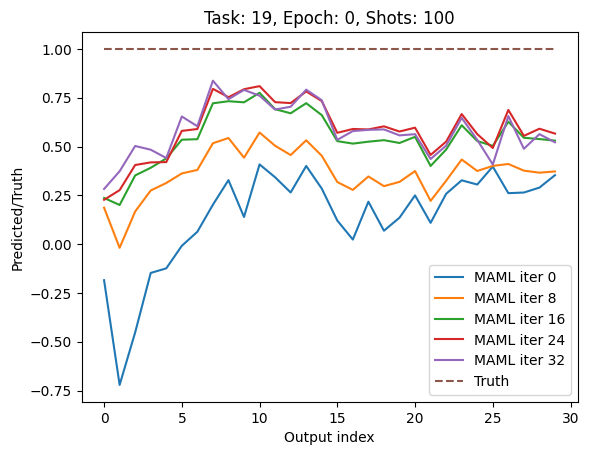

Loss: 0.058849941939115524


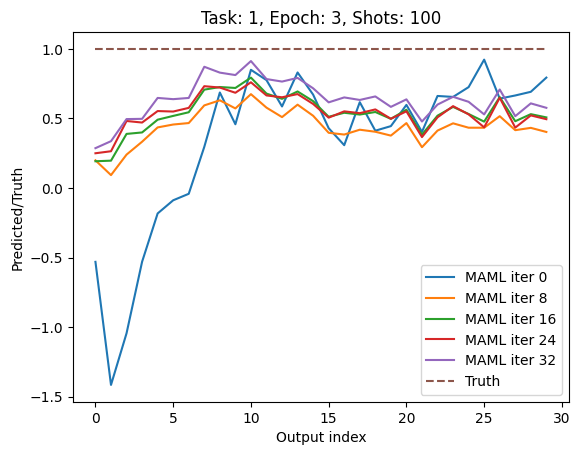

Loss: 0.04517889395356178


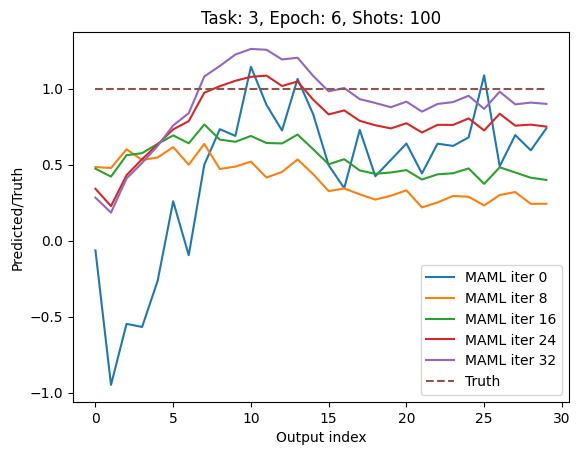

Loss: 0.01240894291549921


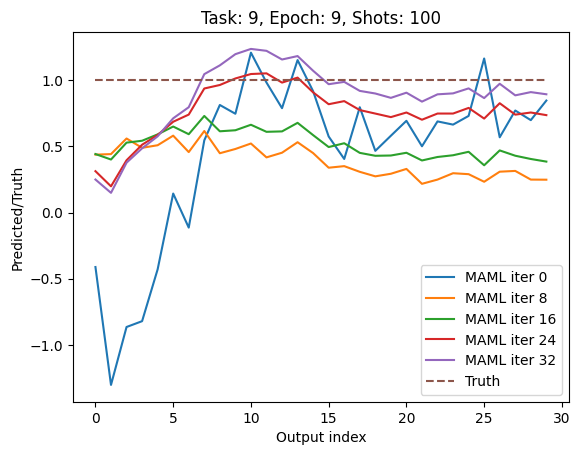

Loss: 0.013239697553217411


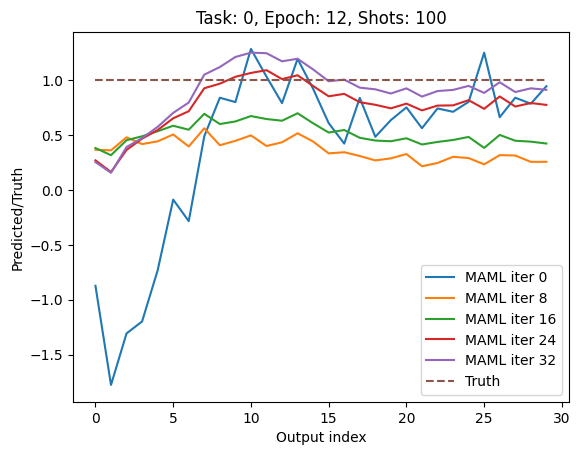

Loss: 0.012991277500987053


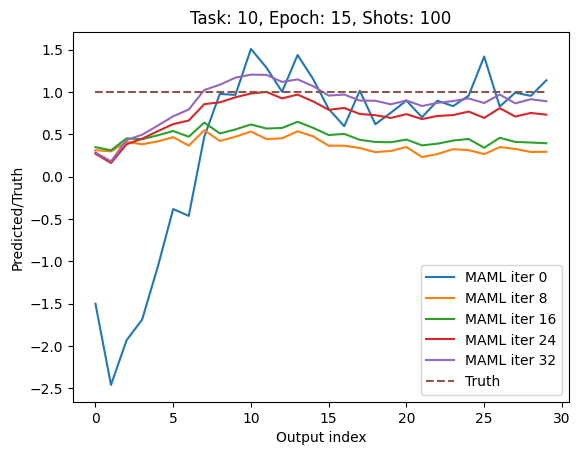

Loss: 0.012356054037809372


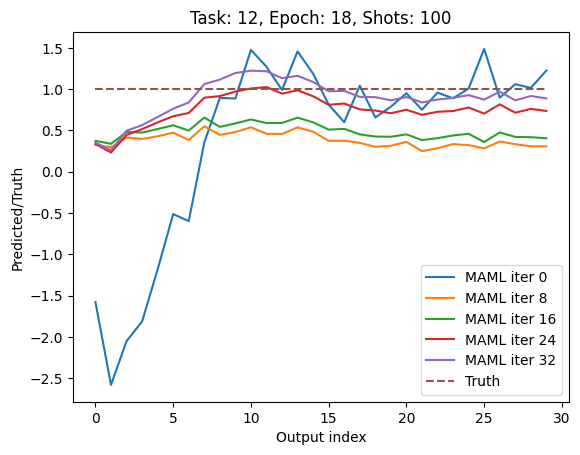

Loss: 0.010547772981226444


In [100]:
# Construct NN architechture
model = nn.Sequential(
    nn.Linear(6, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 30)
)

# MAML train model
CosyMAML = MAML(
    model=model,
    seed=14
)

loss_MAML = CosyMAML.meta_train(
    x_train=X_train,
    y_train=Y_train,
    inner_lr=0.2,
    outer_lr=0.5,
    inner_decay=1e-2,
    outer_decay=1e-2,
    loss_fn=nn.MSELoss(),
    spt_frac=0.8,
    outer_epochs=1,
    inner_epochs=10,
    plot_prog=True,
    scale=True,
    n_shots=100
)

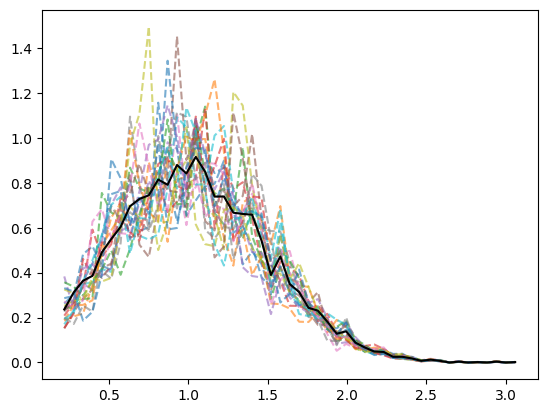

In [118]:
# Now produce a novel test set
novel_pz, novel_midpoints = datamaker.gen_Pz_base(
    0.9,
    0.5,
    gridsize=50
)

n_samples = 2**10
qrd_pz, true_mean = datamaker.gen_Pz_samples(
    novel_pz,
    novel_midpoints,
    seed=24,
    shift=0.02,
    qrd_samples=n_samples
)

plt.figure()
shifts = np.zeros(n_samples)
for i in range(n_samples):
    mean = np.trapz(qrd_pz[i]*novel_midpoints, novel_midpoints)
    shifts[i] = mean - true_mean
    if i % 50 == 0:
        plt.plot(novel_midpoints, qrd_pz[i], alpha=0.6, ls='--')
plt.plot(novel_midpoints, novel_pz, label='True P(z)', c='black')

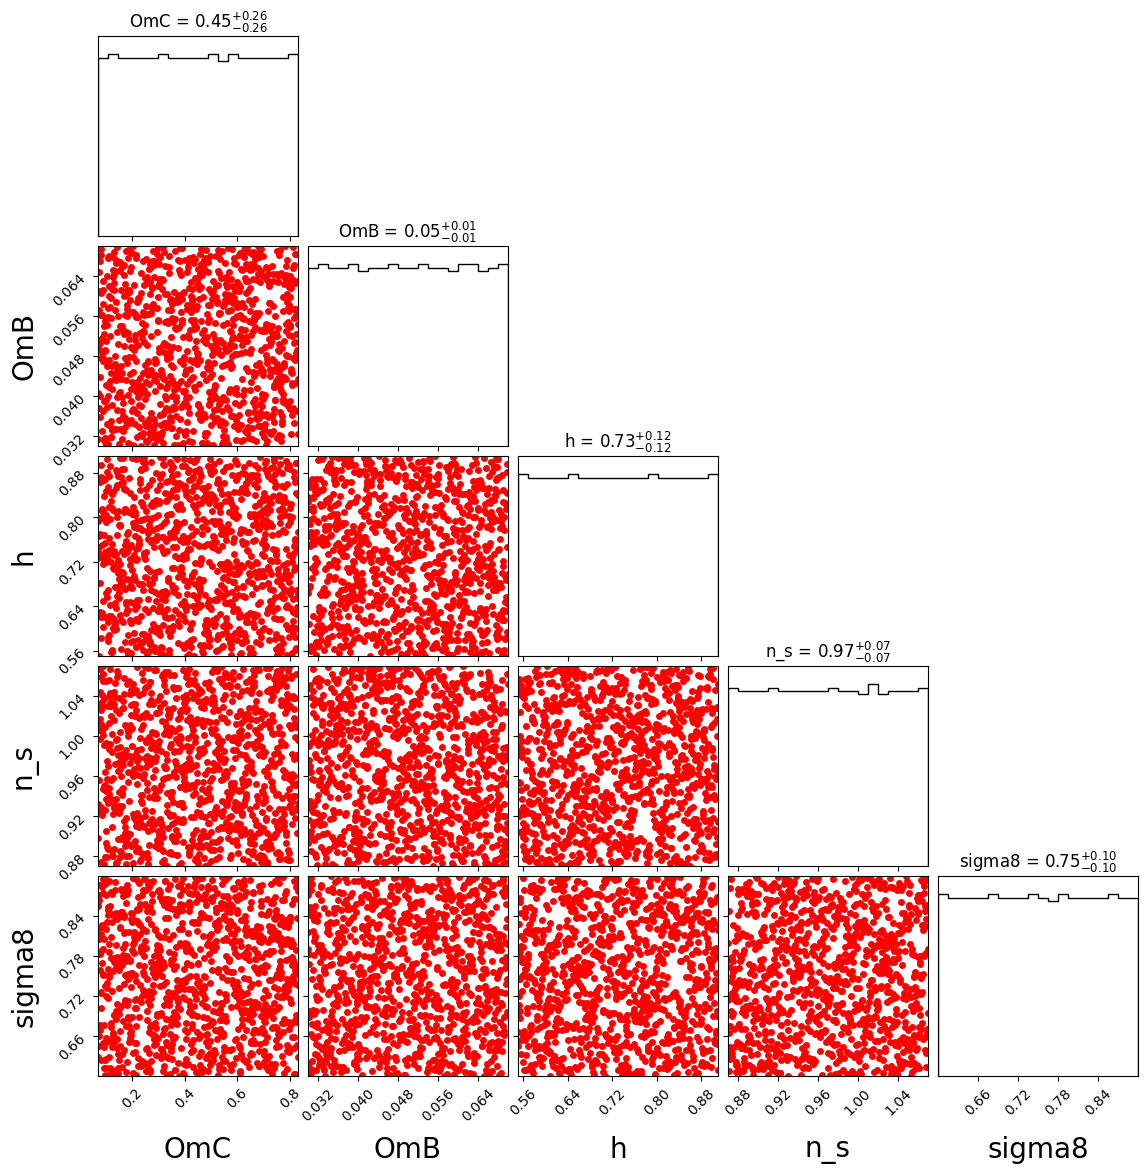

In [122]:
OmM = np.array([0.1, 0.9])
OmB = np.array([0.03, 0.07])
OmC = OmM - OmB

h = np.array([0.55, 0.91])
n_s = np.array([0.87, 1.07])
sigma8 = np.array([0.6, 0.9])

# Generate the cosmology hypercube example (we will regenerate this each time for each task)
cosmo_hypercube = datamaker.gen_hypercube(OmC, OmB, h, n_s, sigma8, n_samples)

# plot the hypercube samples
param_list = ['OmC', 'OmB', 'h', 'n_s', 'sigma8']
df = pd.DataFrame(cosmo_hypercube, columns=param_list)
# Use corner plot to visualize
corner.corner(df, labels=[string for string in param_list], show_titles=True,
              plot_contours=False, plot_density=False, plot_datapoints=True,
              data_kwargs={'alpha': 1,'color': 'red','ms' : 5}, label_kwargs={'fontsize': 20})
plt.show()

In [ ]:
X_novel = np.zeros((n_samples, 6))

for i in range(n_samples):
    X_novel[i] = np.concatenate([cosmo_hypercube[i], shifts[i]])

print